In [ ]:
import os
import torch
from diffusers import StableDiffusionPipeline

HF_HOME = '../.hf_home'
os.environ['HF_HOME'] = HF_HOME

device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

In [3]:
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, cache_dir=os.environ['HF_HOME'])
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

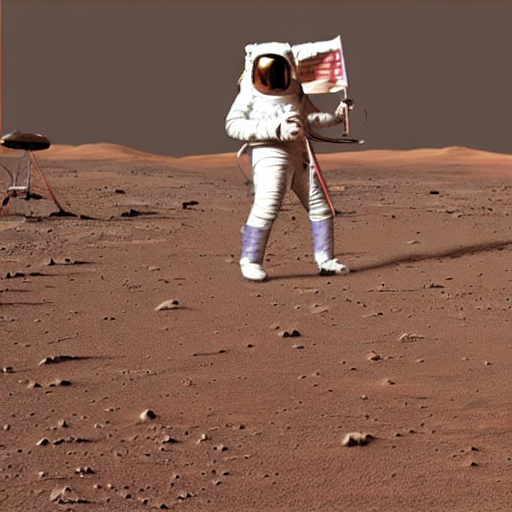

In [4]:
prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]
image